In [ ]:
!pip install spektral
!pip install hyperopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
"""
This example shows how to perform regression of molecular properties with the
QM9 database, using a GNN based on edge-conditioned convolutions in batch mode.
"""

from hyperopt import fmin, tpe, hp, Trials

import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import BatchLoader
from spektral.datasets import QM9
from spektral.layers import ECCConv, GlobalSumPool, GraphMasking

################################################################################
# Config
################################################################################
learning_rate = 1e-3  # Learning rate
epochs = 30  # Number of training epochs
batch_size = 32  # Batch size
neurons = [16, 32 ,48, 64]
batches = [12, 18, 24, 30, 36]

In [ ]:
################################################################################
# Load data
################################################################################
dataset = QM9(amount=1000)  # Set amount=None to train on whole dataset


# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]




44852087/44852087 [==============================] - 2s 0us/step
Loading QM9 dataset.
Reading SDF


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 635.48it/s]


In [ ]:
tuning= {"learning_rate":hp.uniform("learning_rate", 0.0001, 0.01),
         "batch_size":hp.choice("batch_size", batches),
         "neuron_layer1":hp.choice("neuron_layer1", neurons),
         "neuron_layer2":hp.choice("neuron_layer2", neurons)}

In [ ]:
################################################################################
# Build model
################################################################################
class Net(Model):
    def __init__(self, neuron_layer1, neuron_layer2):
        super().__init__()
        self.masking = GraphMasking()
        self.conv1 = ECCConv(neuron_layer1, activation="relu")
        self.conv2 = ECCConv(neuron_layer2, activation="relu")
        self.global_pool = GlobalSumPool()
        self.dense = Dense(n_out)


    def call(self, inputs):
        x, a, e = inputs
        x = self.masking(x)
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        output = self.global_pool(x)
        output = self.dense(output)

        return output

In [ ]:
def pruebas(tuning):
  model = Net(tuning["neuron_layer1"], tuning["neuron_layer2"])
  model.compile(optimizer=Adam(learning_rate=tuning["learning_rate"]), loss="mse")
  loader_tr = BatchLoader(dataset_tr, batch_size=tuning["batch_size"], mask=True)
  model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=epochs)
  loader_te = BatchLoader(dataset_te, batch_size=tuning["batch_size"], mask=True)
  score = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)

  return score


In [ ]:
best = fmin(pruebas, tuning, algo=tpe.suggest, max_evals=20, trials=Trials())
print("Best lr value:", best)

Streaming output truncated to the last 5000 lines.

50/50 [==============================] - 1s 11ms/step - loss: 22011808.0000

Epoch 24/30

50/50 [==============================] - 1s 11ms/step - loss: 21939338.0000

Epoch 25/30

50/50 [==============================] - 1s 11ms/step - loss: 21877756.0000

Epoch 26/30

50/50 [==============================] - 1s 10ms/step - loss: 21800780.0000

Epoch 27/30

50/50 [==============================] - 1s 12ms/step - loss: 21719952.0000

Epoch 28/30

50/50 [==============================] - 1s 12ms/step - loss: 21635716.0000

Epoch 29/30

50/50 [==============================] - 1s 12ms/step - loss: 21563980.0000

Epoch 30/30

50/50 [==============================] - 1s 12ms/step - loss: 21482178.0000

6/6 [==============================] - 0s 9ms/step - loss: 230381.0000

Epoch 1/30

38/38 [==============================] - 3s 13ms/step - loss: 22800266.0000

Epoch 2/30

38/38 [==============================] - 0s 13ms/step - loss: 227948

In [ ]:
model = Net(neurons[best["neuron_layer1"]], neurons[best["neuron_layer2"]])
optimizer = Adam(best["learning_rate"])
model.compile(optimizer=optimizer, loss="mse")

################################################################################
# Fit model
################################################################################
loader_tr = BatchLoader(dataset_tr, batch_size=batch_size, mask=True)
model.fit(loader_tr.load(), steps_per_epoch=loader_tr.steps_per_epoch, epochs=epochs)

################################################################################
# Evaluate model
################################################################################
print("Testing model")
loader_te = BatchLoader(dataset_te, batch_size=batch_size, mask=True)
loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(loss))


Epoch 1/30
29/29 [==============================] - 4s 97ms/step - loss: 22795394.0000
Epoch 2/30
29/29 [==============================] - 3s 103ms/step - loss: 22749512.0000
Epoch 3/30
29/29 [==============================] - 2s 82ms/step - loss: 22609228.0000
Epoch 4/30
29/29 [==============================] - 2s 85ms/step - loss: 22495344.0000
Epoch 5/30
29/29 [==============================] - 2s 80ms/step - loss: 22477152.0000
Epoch 6/30
29/29 [==============================] - 3s 102ms/step - loss: 22472176.0000
Epoch 7/30
29/29 [==============================] - 3s 97ms/step - loss: 22469606.0000
Epoch 8/30
29/29 [==============================] - 2s 84ms/step - loss: 22467330.0000
Epoch 9/30
29/29 [==============================] - 2s 79ms/step - loss: 22465440.0000
Epoch 10/30
29/29 [==============================] - 2s 83ms/step - loss: 22463416.0000
Epoch 11/30
29/29 [==============================] - 3s 113ms/step - loss: 22461654.0000
Epoch 12/30
29/29 [===================

In [ ]:
sample = 0

In [ ]:
test_prediction= model.predict(loader_te.load(), steps=loader_te.steps_per_epoch)
test_prediction

4/4 [==============================] - 0s 24ms/step


array([[ 2.96197174e+02, -1.09542596e+00, -1.77664065e+00, ...,
        -1.00814746e+03, -1.01777252e+03, -9.25648132e+02],
       [ 4.00825714e+02,  2.03281116e+00, -7.94147921e+00, ...,
        -1.58298438e+03, -1.63748218e+03, -1.46665576e+03],
       [ 2.26709259e+02,  3.43180269e-01,  1.94384202e-01, ...,
        -1.15994153e+03, -1.17544238e+03, -1.07453406e+03],
       ...,
       [ 6.01626099e+02, -5.26866722e+00, -6.89029360e+00, ...,
        -1.56782214e+03, -1.58684082e+03, -1.42081165e+03],
       [ 4.22688026e+01,  1.24362011e+01, -1.09629536e+00, ...,
        -1.15505786e+03, -1.20730310e+03, -1.09595850e+03],
       [ 1.37383881e+02, -1.88197541e+00,  3.32376385e+00, ...,
        -1.41624304e+03, -1.43792200e+03, -1.31244775e+03]], dtype=float32)

In [ ]:
dataset_te[sample]['y']

array([ 1.19225200e+01,  3.07744000e+00,  2.77702000e+00,  9.50000000e-02,
        5.29000000e+01, -2.72300000e-01,  9.86000000e-02,  3.70900000e-01,
        5.14305300e+02,  1.37725000e-01, -1.96405320e+02, -1.96399392e+02,
       -1.96398448e+02, -1.96434166e+02,  2.13640000e+01, -1.36089759e+03,
       -1.37050915e+03, -1.37880858e+03, -1.26650832e+03])

In [ ]:
test_prediction[sample]

array([ 2.96197174e+02, -1.09542596e+00, -1.77664065e+00,  9.84849262e+00,
        5.10482521e+01,  2.93655729e+00, -3.13356698e-01, -2.06878376e+00,
        4.67406586e+02, -5.25722027e+00, -2.26810196e+02, -2.23029953e+02,
       -2.28357086e+02, -2.16404984e+02,  1.89187431e+01, -1.01068134e+03,
       -1.00814746e+03, -1.01777252e+03, -9.25648132e+02], dtype=float32)

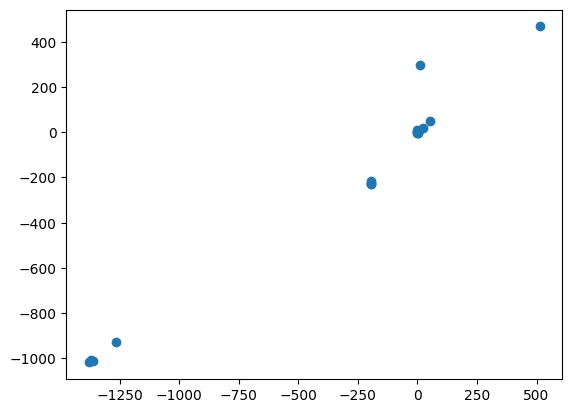

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(dataset_te[sample]['y'],test_prediction[sample])

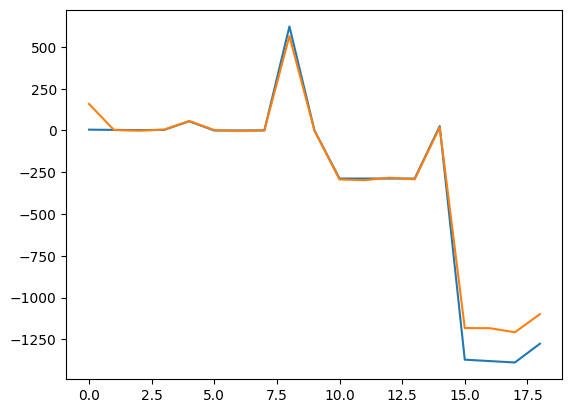

In [ ]:
k = 16 #@param {type:"slider", min:0, max:99, step:1}

#plt.scatter(dataset_te[k]['y'],test_prediction[k])
plt.plot(dataset_te[k]['y'])
plt.plot(test_prediction[k])